# Model Interpretability

In this notebook, we will try to open the black box of our learned models and explore how our models "think" in regards to our data. This will help us see if our model is free of any aggregious errors in what it learned and will help us perform feature importance/selection to hopefully boost the performance of our best model so far. 

In this notebook, we will look at a few strategies of viewing model interpretability. First, we will look at scikit-learn's implementation of feature importance and note how there are some potential pitfalls when using its functions. We will compare its feature importance method with other methods and compare the results. 

Next, we will look at how values of our features affect the model's output by looking at some Partial Dependence Plots. We'll look at what they are and how to interpret them, which will help in interpreting how our model is thinking with our data.

Lastly, we'll look at a powerful library that can do all of the above, named Shap. This will help uncover even deeper the inner workings of our models. Let's begin.


Load all of our dependcies. 

In [63]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import scipy.stats
sns.set()
%matplotlib inline
from Modules import *
from sklearn.model_selection import train_test_split
from sklearn import metrics 
import xgboost as xgb

In [4]:
#load in our final dataframe
df = pd.read_csv('Data/Final_trimmed_sequential_data.csv', index_col= 0)
df.head()

AGE  Y  SEX_Female  SEX_Male  EDUCATION_Graduate School  EDUCATION_Other  \
0   24  1           1         0                          0                0   
1   26  1           1         0                          0                0   
2   34  0           1         0                          0                0   
3   37  0           1         0                          0                0   
4   57  0           0         1                          0                0   

   EDUCATION_University  MARRIAGE_Married  MARRIAGE_Non-married  \
0                     1                 1                     0   
1                     1                 0                     1   
2                     1                 0                     1   
3                     1                 1                     0   
4                     1                 1                     0   

   PERCENT_OF_LIMIT_BAL1      ...        PAY_4_Other  \
0               0.195650      ...                  0   
1               0.022350      ...                  1   
2               0.308011      ...                  1   
3               0.899800      ...                  1   
4               0.132340      ...                  1   

   PAY_4_more_than_two_month_late  PAY_4_on_time  PAY_4_one_month_late  \
0                               0              1                     0   
1                               0              0                     0   
2                               0              0                     0   
3                               0              0                     0   
4                               0              0                     0   

   PAY_5_Other  PAY_5_more_than_two_month_late  PAY_5_on_time  PAY_6_Other  \
0            1                               0              0            1   
1            1                               0              0            0   
2            1                               0              0            1   
3            1                               0              0            1   
4            1                               0              0            1   

   PAY_6_more_than_two_month_late  PAY_6_on_time  
0                               0              0  
1                               1              0  
2                               0              0  
3                               0              0  
4                               0              0  

[5 rows x 53 columns]

## Scikit-Learn Implementation

We first want to highlight the `feature_importance` function that scikit learn implements for tree-based family of models. We will show that the results are not always consistent. We'll load our best xgboost model and use the `feature_importance` function and compare the results with xgboost's own implementation of `plot_importance`, and finally look at another method of feature importance to compare.

 

In [8]:
#set up our model and train/test split
from sklearn.externals import joblib

Train_data, test_data = train_test_split(df, test_size = 0.2, random_state = 2019)

target = 'Y'
predictors = [x for x in Train_data.columns if x not in [target]]

loaded_model = joblib.load('Models/xgboost3.dat')


In [12]:
#show the test results, ensure model works
y_pred = loaded_model.predict(test_data[predictors])
print(f"Test Accuracy: {metrics.accuracy_score(test_data[target], y_pred)}")
print(f"Test AUC: {metrics.roc_auc_score(test_data[target], y_pred)}")
print(f"Test F1: {metrics.f1_score(test_data[target], y_pred)}")




Test Accuracy: 0.7846666666666666
Test AUC: 0.7103046462252506
Test F1: 0.5365853658536585


Now, we'll look at the feature importance scores for this model using scikit-learn's api. For convenience sake, we'll use the top 15 features.


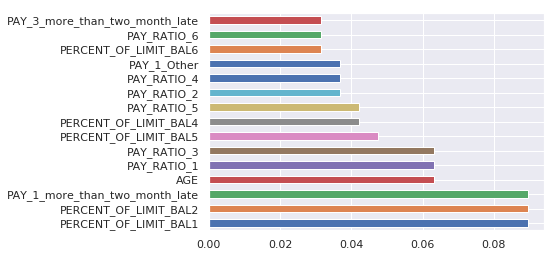

In [62]:
importances = pd.Series(loaded_model.feature_importances_, index=test_data[predictors].columns)
importances.nlargest(15).plot(kind='barh')

From this chart, we can see that the most important feature in the model are  `PAY_1_more_than_two_months_late`, `PERCENT_OF_LIMIT_BAL2`, and `PERCENT_OF_LIMIT_BAL1`  Then, there are some features that have a similar importance to each other, such as his or her age, and then their payment ratio history. It seems that the only feature describing the timing  of payments that is important is the most recent month's payment timing. After that, the ratio of a client's payment to his or her bill, along with the ratio of his or her oustanding balance compared to the balance limit are the more important features. Wholistically, payment patterns appear to be most important; it's all about the money!

This, of course, is useful, but one question that the modeler needs to always ask themselves is how much can he or she trust these findings? First off, do these findings make sense? Is age, according to the scores, really a high ranking important attribute about a customer? Second of all, we don't know for sure how the values of the features impact the model's thinking. For instance, could it be that the model acutally found that younger customers had a _lower_ chance of defaulting, when in the real world it could be the complete opposite? If this were the case, one would not have complete trust that this model is learning the appropriate patterns in the data; it might be performing well due to false findings.

What is important is to remember how sklearn implements feature importance; it does so by calculating the decrease in mean impurity. When training a tree, what is computed is how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. However, there are some problems with this method. For one, the model can be biased in selected features with more categories. Secondly, correlated features' importance scores may be incorrect; for two or more correlated features, from the point of view from the model, any of  correlated features can be used as a predictor, with no significant 'preference' between them. However, once one of the correlated features is used, the importance of the other features are reduced, since the level of impurity that the latter correlated features can reduce has, in fact, already been reduced by that first correated feature, resulting in a lower importance score for the latter correlated features.


In order to ensure our models findings, we'll compare these scores with two other mehods of calculating feature importances: xgboost library's own `plot_importances` function, and a library named ELI5, which will conduct permutated feature importance.
In xgboost's function, one can specify one of three methods of calculating the importance score: "weight" is the number of times a feature appears in a tree, "gain" is the average gain of splits which use the feature, "cover" is the average coverage of splits which use the feature. "weight" will give the exact same importances as the scikit-learn function does, so we will demonstrate the 'gain' method, and compare results.



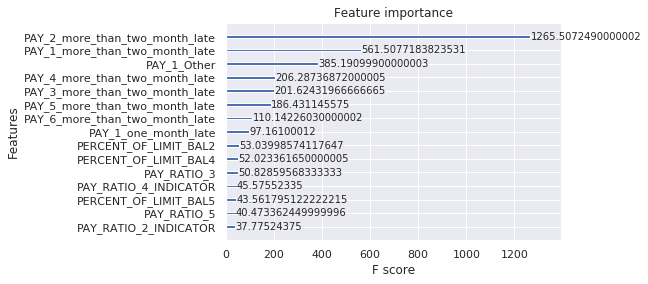

In [70]:
#xgboost method
xgb.plot_importance(loaded_model, max_num_features=15,importance_type='gain')

This chart shows that the most important features are essentially opposite of the first chart; the timing of payments for each period is wholistically the most important. WHAT DOES THIS MEAN? 

In [13]:
import eli5
from eli5.sklearn import PermutationImportance

column = X_train.columns
rf = clf2.fit(X_train, y_train)
perm = PermutationImportance(rf).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = list(column), top=27)

From this, we can see that the most important features and their order are in fact different from sklearn's ordering. Why is this?

The difference is in the way that the measure of importance is calculated. sklearn implements feature importance by calculating the decrease in mean impurity. When training a tree, what is computed is how much each feature decreases the weighted impurity in a tree. For a forest, the impurity decrease from each feature can be averaged and the features are ranked according to this measure. However, there are some problems with this method. For one, the model can be biased in selected features with more categories. Secondly, correlated features' importance scores may be incorrect; for two or more correlated features, from the point of view from the model, any of  correlated features can be used as a predictor, with no significant 'preference' between them. However, once one of the correlated features is used, the importance of the other features are reduced, since the level of impurity that the latter correlated features can reduce has, in fact, already been reduced by that first correated feature, resulting in a lower importance score for the latter correlated features.

A more stable way to look at feature importance is to randomly permute the values of the feature and measure the decrease in accuracy between models without  permuted feautre and models with the permuted feature. In the eli5 PermutationImportance class, feature importances are calculated in a similar fashion, which is what the results in the output above show. For each feature, the values are permutated, and the degree in decrease in accuracy with its values permutated is what determines the feature importance score. 

Text(0,0.5,'Feature')

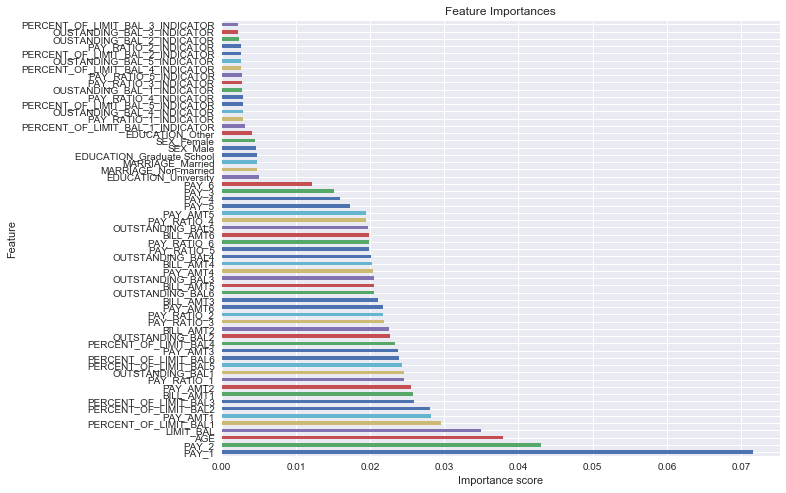

In [10]:
plt.figure(figsize=(10,8))

feature_imp = pd.Series(clf2.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_imp.plot(kind = 'barh')
plt.title("Feature Importances")
plt.xlabel('Importance score')
plt.ylabel('Feature')


We can check local examples to see how the values of these features affect the model's predictions. We use the INSERT HERE.

In [72]:
print(f"the model predicted:")
eli5.show_prediction(rf, doc= X_val.values[2019], 
                     show_feature_values = True, 
                     feature_names = list(X_train.columns),
                    )

the model predicted:


In [21]:
# set up random search

from sklearn.model_selection import RandomizedSearchCV

#define number of trees 
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 20)]

#define number of features to use at every split
#max_features = ['auto', .60]

#define max depth in trees
#max_depth = [int(t) for t in np.linspace(start = 10, stop = 100, num = 10)]

#define min number of samples to split a node
#min_samples_split = [2, 5, 8]

#define min number of samples at each leaf node
min_samples_leaf = [1, 2, 4]

#define method of sample selection for each tree
#bootstrap = [True, False]


#create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
                }



In [22]:

#perform the random seach, using 3-fold cross_validation
#we'll search over 100 different combinations

clf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=clf, param_distributions=random_grid,
                              n_iter = 100, cv = 3,
                               random_state = 2019, n_jobs = -1
                              )

#fit the model
rf_random.fit(X, y)



KeyboardInterrupt: 

From the UCI dataset website:

This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables: 
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- X2: Gender (1 = male; 2 = female). 
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- X4: Marital status (1 = married; 2 = single; 3 = others). 
- X5: Age (year). 
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005;
- X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005. 
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005. 